In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

%matplotlib inline

In [2]:
import warnings

# Before fitting your models, suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


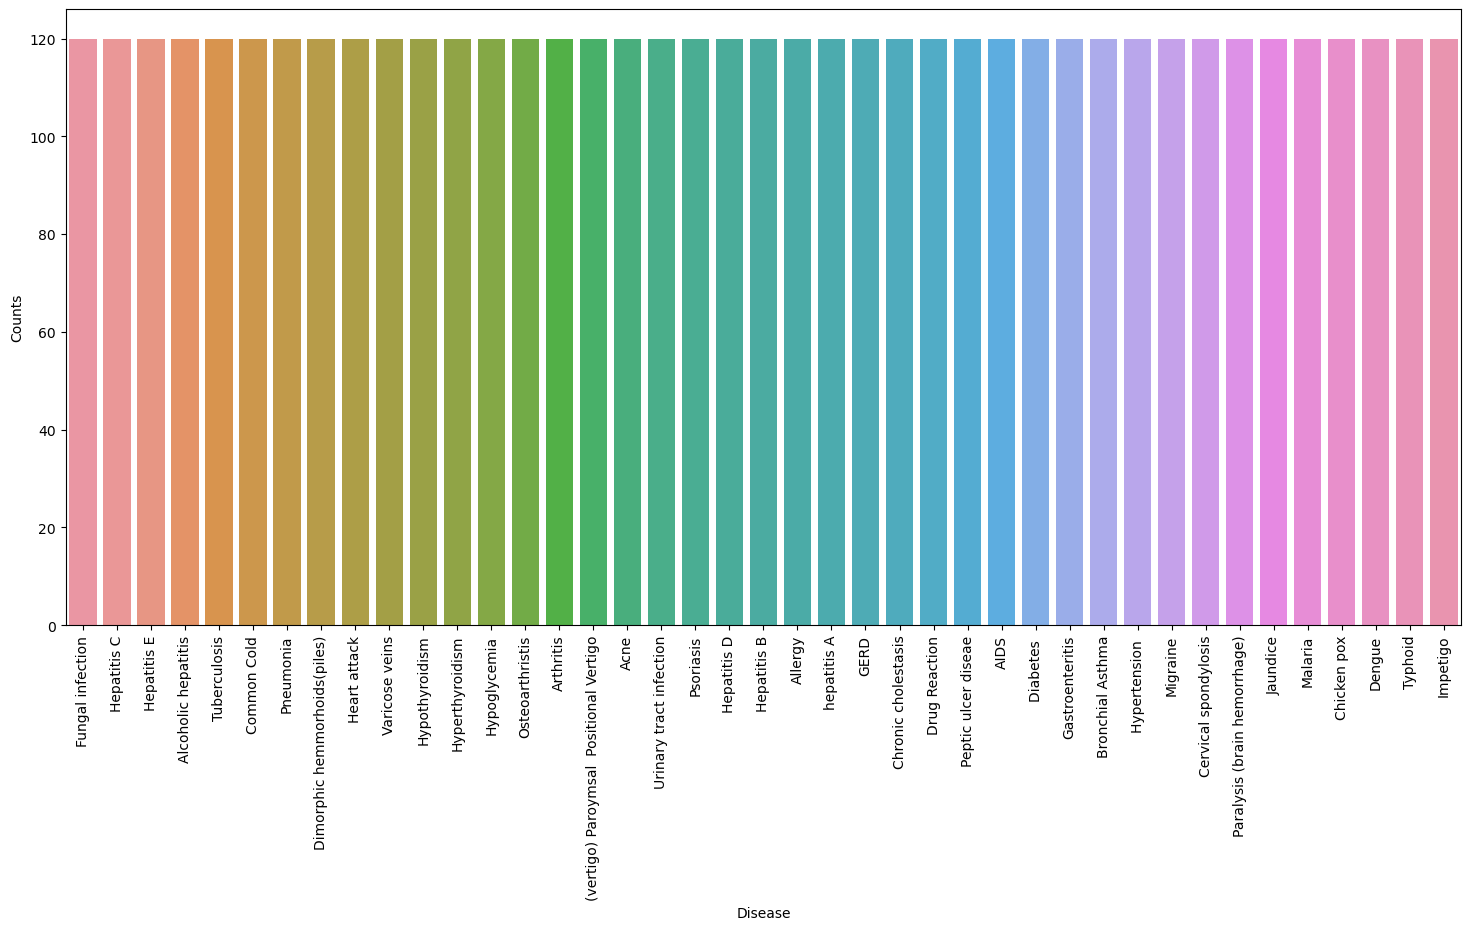

In [5]:
Data_path = 'Data/Training.csv'
data = pd.read_csv(Data_path).dropna(axis=1)

# checking the dataset is balanced or not.
disease_counts = data['prognosis'].value_counts()
temp_df = pd.DataFrame({
    "Disease" : disease_counts.index,
    "Counts" : disease_counts.values
})

plt.figure(figsize=(18,8))
sns.barplot(x = 'Disease', y = 'Counts', data = temp_df)
plt.xticks(rotation=90)
plt.show()

In [6]:
encoder = LabelEncoder()
data['prognosis'] = encoder.fit_transform(data['prognosis'])

In [7]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=24)

print(f'Train: {X_train.shape}, {Y_train.shape}')
print(f'Test: {X_test.shape}, {Y_test.shape}')

Train: (3936, 132), (3936,)
Test: (984, 132), (984,)


In [8]:
#defining scoring matric for k-fold cross validation
def  cv_scoring(estimator,X, Y):
    return accuracy_score(Y, estimator.predict(X))

#initializing models
models = {
    "SVC" : SVC(),
    "Gaussian NB" : GaussianNB(),                                                       
    "Random Forest" : RandomForestClassifier(random_state=18)
}

#producing cross-validation score for the models
for model_name in models:
    model = models[model_name]
    scores = cross_val_score(model, X, Y, cv=10, n_jobs=-1, scoring=cv_scoring)

    print("=="*30)
    print(model_name)
    print(f'Scores: {scores}')
    print(f'Mean Score: {np.mean(scores)}')

SVC
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Gaussian NB
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Random Forest
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0


Accuracy on train data by SVM Classifier : 100.0
Accuracy on test data by SVM classifier : 100.0


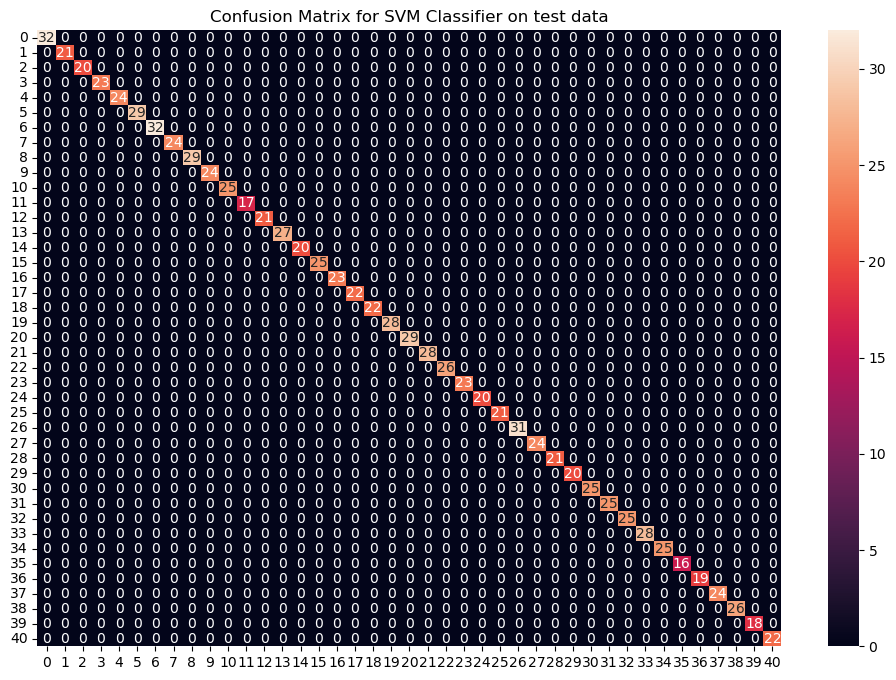

Accuracy on train data by Naive Bayes Classifier : 100.0
Accuracy on test data by Naive Bayes Classifier : 100.0


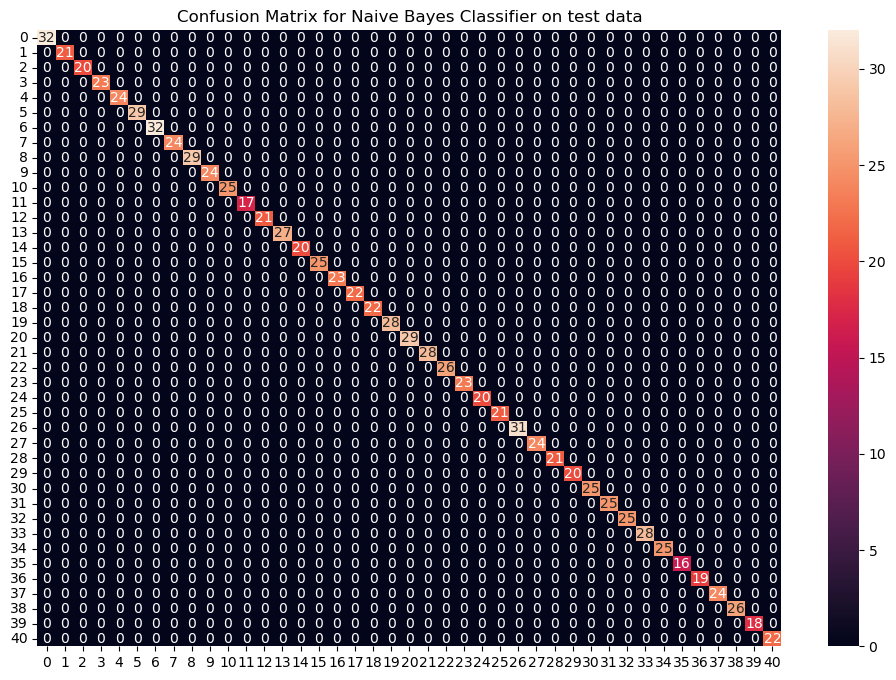

Accuracy on train data by Ramdom Forest : 100.0
Accuracy on test data by Ramdom Forest : 100.0


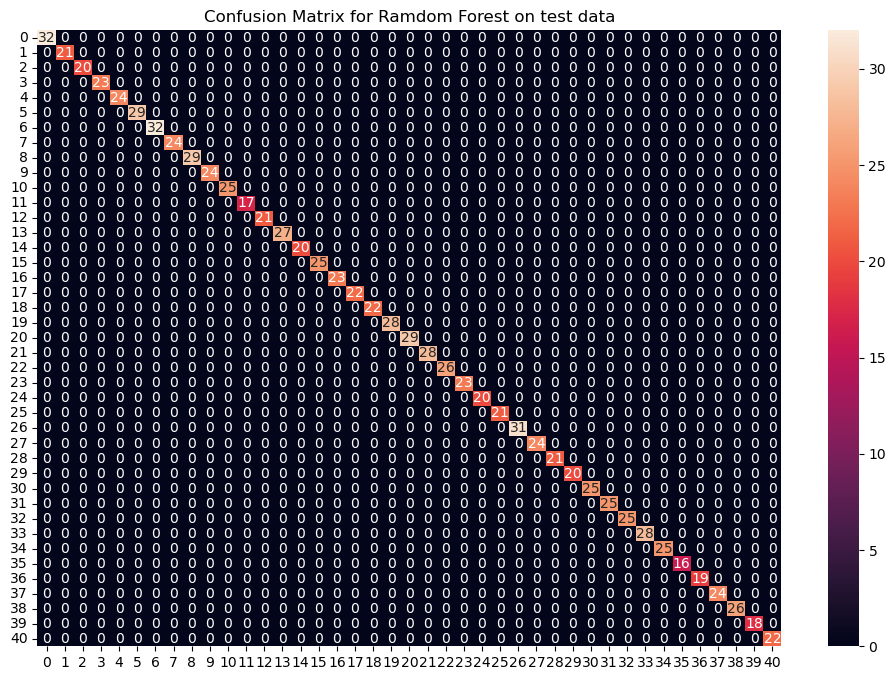

In [9]:
#training and testing SVM classifier
svm_model = SVC()
svm_model.fit(X_train, Y_train)
preds = svm_model.predict(X_test)

print(f'Accuracy on train data by SVM Classifier : {accuracy_score(Y_train, svm_model.predict(X_train))*100}')
print(f'Accuracy on test data by SVM classifier : {accuracy_score(Y_test, preds)*100}')
print("="*40)
cf_matrix = confusion_matrix(Y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix,annot=True)
plt.title("Confusion Matrix for SVM Classifier on test data")
plt.show()

#training and testing Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, Y_train)
preds = nb_model.predict(X_test)

print(f'Accuracy on train data by Naive Bayes Classifier : {accuracy_score(Y_train, nb_model.predict(X_train))*100}')
print(f'Accuracy on test data by Naive Bayes Classifier : {accuracy_score(Y_test, preds)*100}')
print("="*40)
cf_matrix = confusion_matrix(Y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix,annot=True)
plt.title("Confusion Matrix for Naive Bayes Classifier on test data")
plt.show()

#training and testing Ramdom Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, Y_train)
preds = rf_model.predict(X_test)

print(f'Accuracy on train data by Ramdom Forest : {accuracy_score(Y_train, rf_model.predict(X_train))*100}')
print(f'Accuracy on test data by Ramdom Forest : {accuracy_score(Y_test, preds)*100}')
print("="*40)
cf_matrix = confusion_matrix(Y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix,annot=True)
plt.title("Confusion Matrix for Ramdom Forest on test data")
plt.show()


Accuracy on test dataset by the combined model: 100.0


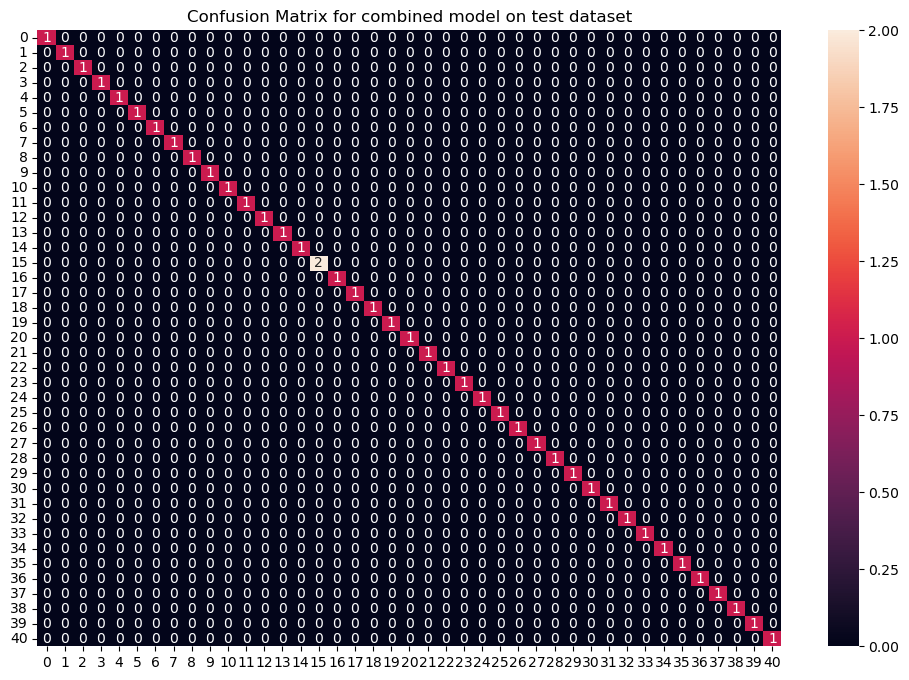

In [10]:
#training the model on whole data
final_svm_model = SVC()
final_nb_model = GaussianNB()
final_rf_model = RandomForestClassifier()
final_svm_model.fit(X, Y)
final_nb_model.fit(X, Y)
final_rf_model.fit(X, Y)

#reading the test data
test_data = pd.read_csv('Data/Testing.csv').dropna(axis=1)

test_X = test_data.iloc[:,:-1]
test_Y = encoder.transform(test_data.iloc[:,-1])

#making predictions using all the models

svm_preds = final_svm_model.predict(test_X)
nb_preds = final_nb_model.predict(test_X)
rf_preds = final_rf_model.predict(test_X)

final_preds = [mode([i,j,k], keepdims=True)[0][0] for i, j,k in zip(svm_preds, nb_preds, rf_preds)]

print(f'Accuracy on test dataset by the combined model: {accuracy_score(test_Y, final_preds)*100}')

cf_matrix = confusion_matrix(test_Y, final_preds)
plt.figure(figsize=(12,8))

sns.heatmap(cf_matrix, annot=True)
plt.title('Confusion Matrix for combined model on test dataset')
plt.show()

In [14]:
symptoms = X.columns.values

symptom_index = {}
for index, value in enumerate(symptoms):
    symptom= " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index

data_dict = {
    "symptom_index" : symptom_index,
    "predictions_classes" : encoder.classes_ 
}

def predictDisease(symptoms):
    symptoms = symptoms.split(',')

    input_data = [0]*len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1

        input_data = np.array(input_data).reshape(1,-1)


        rf_prediction = data_dict["predictions_classes"][final_rf_model.predict(input_data)[0]]
        nb_prediction = data_dict["predictions_classes"][final_nb_model.predict(input_data)[0]]
        svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]

        final_prediction = mode([rf_prediction, nb_prediction, svm_prediction], axis=0,keepdims=True,  nan_policy='omit')[0][0]
        predictions = {
            "rf_model_prediction" :rf_prediction,
            "nb_model_prediction" :nb_prediction,
            "svm_model_prediction" :svm_prediction,
            "final_prediction" : final_prediction
        }
        return predictions

In [15]:
# testing the function
Input_Symptoms=input('Enter the Diseases:')
disease = predictDisease(Input_Symptoms)
# type(disease)
print(disease);
print("="*30)
final_disease=disease["final_prediction"]
print("Maybe You are having: ", final_disease);
print("Your Symptoms: ", Input_Symptoms);
# print(predictDisease(disease))

{'rf_model_prediction': 'Paralysis (brain hemorrhage)', 'nb_model_prediction': 'Paralysis (brain hemorrhage)', 'svm_model_prediction': 'Paralysis (brain hemorrhage)', 'final_prediction': 'Paralysis (brain hemorrhage)'}
Maybe You are having:  Paralysis (brain hemorrhage)
Your Symptoms:  Headache, Vomiting, Stomach_Pain


In [16]:
import csv

In [17]:
disease_descriptions={}

# description_file = pd.read_csv('Data/symptom_Description.csv')
# description_file.head()
predicted_disease = final_disease

with open('Data/symptom_Description.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row 

    for row in reader:
        disease_name, description = row  
        disease_descriptions[disease_name] = description

if predicted_disease in disease_descriptions:
    description = disease_descriptions[predicted_disease]
    print(f"Description of {predicted_disease}: {description}")
else:
    print(f"Description for {predicted_disease} not found.")

Description of Paralysis (brain hemorrhage): Intracerebral hemorrhage (ICH) is when blood suddenly bursts into brain tissue, causing damage to your brain. Symptoms usually appear suddenly during ICH. They include headache, weakness, confusion, and paralysis, particularly on one side of your body.


In [18]:
disease_precautions={}

with open('Data/symptom_precaution.csv','r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)

    for row in reader:
        disease,precaution_1, precaution_2, precaution_3, precaution_4 = row
        disease_precautions[disease]= [precaution_1, precaution_2, precaution_3]

    if predicted_disease in disease_precautions:
         precautions = disease_precautions[predicted_disease]
         print(f"Precautions for {predicted_disease}:")
         for i, precaution in enumerate(precautions, start=1):
            print(f"Precaution {i}: {precaution}")
    else:
        print(f"Precautions for {predicted_disease} not found.")

Precautions for Paralysis (brain hemorrhage):
Precaution 1: massage
Precaution 2: eat healthy
Precaution 3: exercise
